In [1]:
import json
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
import gmaps
from config import (g_key, api_key, email)

gmaps.configure(api_key=g_key)

In [2]:
#Create file path and read in the file

health_data_path= "Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System (version 1).csv"
read_data = pd.read_csv(health_data_path)
read_data.describe()

,"eek, an",YearEnd,Data_Value_Unit,Data_Value,Data_Value_Alt,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,LocationID
count,63028.000000,63028.000000,0.0,56796.000000,56796.000000,56796.000000,56796.000000,56796.000000,63028.000000
mean,2014.481120,2014.481120,NaN,30.968058,30.968058,26.702317,35.806650,3790.852630,30.775655
std,2.297134,2.297134,NaN,10.139928,10.139928,9.953460,11.066531,19367.349744,17.346195
min,2011.000000,2011.000000,NaN,0.900000,0.900000,0.300000,3.000000,50.000000,1.000000
25%,2013.000000,2013.000000,NaN,24.200000,24.200000,20.000000,28.400000,546.000000,17.000000
50%,2015.000000,2015.000000,NaN,30.700000,30.700000,26.500000,35.500000,1163.000000,30.000000
75%,2017.000000,2017.000000,NaN,36.600000,36.600000,32.500000,41.700000,2459.000000,45.000000
max,2018.000000,2018.000000,NaN,77.600000,77.600000,69.500000,87.700000,476876.000000,78.000000


In [3]:
# Extract only the columns needed
new_df = pd.DataFrame(read_data[["YearEnd","LocationDesc","Question","Data_Value"]])

# Extract data from only year 2017 - air quality data only contains info for 2017
clean_df = new_df.loc[new_df.YearEnd == 2017]
clean_df.head()

,YearEnd,LocationDesc,Question,Data_Value
8960,2017,Alaska,Percent of adults aged 18 years and older who ...,NaN
8961,2017,Alaska,Percent of adults aged 18 years and older who ...,34.3
8962,2017,Alaska,Percent of adults aged 18 years and older who ...,27.5
8963,2017,Alaska,Percent of adults aged 18 years and older who ...,31.4
8964,2017,Alaska,Percent of adults aged 18 years and older who ...,NaN


In [4]:
# Group dataframe by question and take the average of the data values. Rename columns

final_health_data = pd.DataFrame(clean_df.groupby(["Question", "LocationDesc"]).mean()["Data_Value"].reset_index()).rename(columns= {"LocationDesc": "state"})
final_health_data.head()

,Question,state,Data_Value
0,Percent of adults aged 18 years and older who ...,Alabama,33.792000
1,Percent of adults aged 18 years and older who ...,Alaska,31.858333
2,Percent of adults aged 18 years and older who ...,Arizona,34.707407
3,Percent of adults aged 18 years and older who ...,Arkansas,36.272000
4,Percent of adults aged 18 years and older who ...,California,35.670370


In [5]:
# Determined that there are some outlier states - Puerto Rico and Virgin Islands. Drop these states

final_health = final_health_data[(final_health_data.state != "Puerto Rico") & (final_health_data.state != "Virgin Islands")]
final_health.head()

,Question,state,Data_Value
0,Percent of adults aged 18 years and older who ...,Alabama,33.792000
1,Percent of adults aged 18 years and older who ...,Alaska,31.858333
2,Percent of adults aged 18 years and older who ...,Arizona,34.707407
3,Percent of adults aged 18 years and older who ...,Arkansas,36.272000
4,Percent of adults aged 18 years and older who ...,California,35.670370


In [6]:
# Questions #3-6 are very similar and we want to consolidate those. Replace each question with a shortened statement to read easier

condense_health = final_health.replace(to_replace = "Percent of adults aged 18 years and older who have an overweight classification", value ="overweight").replace(to_replace ="Percent of adults aged 18 years and older who have obesity", value = "obese").replace(to_replace ="Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)", value ="moderate-intense physical activity").replace(to_replace ="Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week", value ="moderate-intense physical activity").replace(to_replace ="Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)", value ="moderate-intense physical activity").replace(to_replace ="Percent of adults who engage in muscle-strengthening activities on 2 or more days a week", value ="moderate-intense physical activity").replace(to_replace ="Percent of adults who engage in no leisure-time physical activity", value ="no physical activity").replace(to_replace ="Percent of adults who report consuming fruit less than one time daily", value ="less than one fruit per day").replace(to_replace ="Percent of adults who report consuming vegetables less than one time daily", value ="less than one vegetable per day")

In [7]:
# Print unique question in health datadrame to ensure the replace funciton worked
condense_health.head()
condense_health["Question"].unique()

array(['overweight', 'obese', 'moderate-intense physical activity',
       'no physical activity', 'less than one fruit per day',
       'less than one vegetable per day'], dtype=object)

In [68]:
q1 = condense_health[condense_health["Question"] == "overweight"]
q2 = condense_health[condense_health["Question"] == "obese"]
q3 = condense_health[condense_health["Question"] == "moderate-intense physical activity"]
q4 = condense_health[condense_health["Question"] == "no physical activity"]
q5 = condense_health[condense_health["Question"] == "less than one fruit per day"]
q6 = condense_health[condense_health["Question"] == "less than one vegetable per day"]

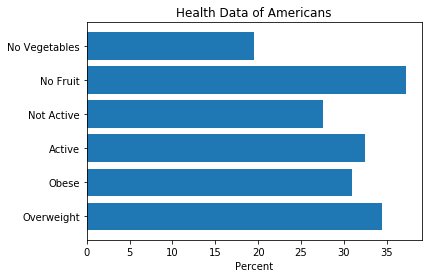

In [124]:
labels = ["Overweight", "Obese", "Active", "Not Active", "No Fruit", "No Vegetables"]
means = [q1["Data_Value"].mean(), q2["Data_Value"].mean(), q3["Data_Value"].mean(), q4["Data_Value"].mean(), q5["Data_Value"].mean(), q6["Data_Value"].mean()]
plt.barh(labels, means)
plt.title("Health Data of Americans")
plt.xlabel("Percent")
plt.show()

In [35]:
# Parameters for API Health Data url

# email = "lilu216@hotmail.com"
# api_key = "baygoose48"
base_url = "https://aqs.epa.gov/data/api/annualData/byState?"
param = "44201"
bdate = "20170101"
edate = "20171231"

# Sample request
url_alabama_co = f"{base_url}email={email}&key={api_key}&param={param}&bdate={bdate}&edate={edate}&state=01"
response = requests.get(url_alabama_co).json()

print(json.dumps(response, indent=4, sort_keys=True))

{
    "Data": [
        {
            "arithmetic_mean": 0.042644,
            "cbsa": "Birmingham-Hoover, AL",
            "cbsa_code": "13820",
            "certification_indicator": "Certified",
            "city": "Birmingham",
            "county": "Jefferson",
            "county_code": "073",
            "date_of_last_change": "2018-07-20",
            "datum": "WGS84",
            "event_type": "No Events",
            "exceptional_data_count": 0,
            "fiftieth_percentile": 0.043,
            "first_max_datetime": "2017-05-15 13:00",
            "first_max_n_o_datetime": null,
            "first_max_nonoverlap_value": null,
            "first_max_value": 0.094,
            "fourth_max_datetime": "2017-05-10 15:00",
            "fourth_max_value": 0.069,
            "latitude": 33.553056,
            "local_site_name": "North Birmingham",
            "longitude": -86.815,
            "method": "INSTRUMENTAL - ULTRA VIOLET ABSORPTION",
            "metric_used": "Daily ma

In [36]:
# Set up query url

state_query_url = f"{base_url}email={email}&key={api_key}&param={param}&bdate={bdate}&edate={edate}&state="

# Set up empty lists for data in each column
states = []
lat = []
long = []
mean = []
max_value = []

# Create a list of state codes so our request can loop through and pull each state
state_code = ["01", "02", "04", "05", "06", "08", "09", "10", "11", "12", "13", "15", "16", "17", "18", "19", "20", "21", "22", 
              "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41",
              "42", "44", "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56", "66", "72", "78"]

# Loop through each state code and pull mean and max No2 values for all locations in each state
for code in state_code:
    response = requests.get(state_query_url + code).json()
    try:
        states.extend([x['state'] for x in response['Data']])
        mean.extend([x['arithmetic_mean'] for x in response['Data']])
        max_value.extend([x['first_max_value'] for x in response['Data']])
        lat.extend([x['latitude'] for x in response['Data']])
        long.extend([x['longitude'] for x in response['Data']])

    except: 
        print("This state has no data", code)

In [37]:
# create a dictionary of lists
o3_dict = {
    "state": states,
    "avg o3": mean,
    "max o3": max_value,
    "lat": lat,
    "long": long
}

# Create a dataframe from lists
o3_df = pd.DataFrame(o3_dict)
o3_df.describe()

,avg o3,max o3,lat,long
count,5664.000000,5664.000000,5664.000000,5664.000000
mean,0.043768,0.076100,37.806247,-95.834244
std,0.005802,0.012833,4.864738,16.118532
min,0.006021,0.026000,18.177939,-158.088613
25%,0.040216,0.068000,34.135525,-111.543600
50%,0.043396,0.074000,38.558288,-92.093080
75%,0.047269,0.082000,41.066065,-82.619053
max,0.070138,0.158000,64.845690,-65.915482


In [38]:
# Change data types to float and create a heatmap showing locations and levels on o3

No2max = o3_df["max o3"].astype(float)
locations = o3_df[["lat", "long"]].astype(float)

fig = gmaps.figure()
layer = gmaps.heatmap_layer(locations, weights=No2max, dissipating=False, max_intensity=.15, point_radius = 1)
fig.add_layer(layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [67]:
# Group dataframe by state and calculate the mean for No2 levels and the max for max No2 levels
# Rename columns so that are no longer in tuples

clean_air_df = o3_df.groupby("state").agg({"avg o3": "mean", "max o3": "max"}).reset_index()
clean_air_df.rename(columns="".join, inplace=True)
clean_air_df.head()

,state,avg o3,max o3
0,Alabama,0.040627,0.094
1,Alaska,0.028044,0.054
2,Arizona,0.049570,0.114
3,Arkansas,0.041574,0.093
4,California,0.046155,0.158


In [40]:
# Create seperate dataframes for specific questions: "Phyisical Acivity" and "No Physical Activity"

active_df = condense_health.loc[condense_health.Question == "moderate-intense physical activity"]
no_active_df = condense_health.loc[condense_health.Question == "no physical activity"]

In [41]:
active_df

,Question,state,Data_Value
110,moderate-intense physical activity,Alabama,42.492000
111,moderate-intense physical activity,Alaska,57.166667
112,moderate-intense physical activity,Arizona,51.222222
113,moderate-intense physical activity,Arkansas,44.900000
114,moderate-intense physical activity,California,57.285185
...,...,...,...
325,moderate-intense physical activity,Virginia,32.542308
326,moderate-intense physical activity,Washington,32.414815
327,moderate-intense physical activity,West Virginia,23.134783
328,moderate-intense physical activity,Wisconsin,30.650000


In [42]:
# Because we consolidated 4 similar questions into one, we need to groupby state again

active_df = active_df.groupby("state").agg({"Data_Value": "mean", "Question": "max"}).reset_index()
active_df.rename(columns="".join, inplace=True)
active_df.head()

,state,Data_Value,Question
0,Alabama,27.654000,moderate-intense physical activity
1,Alaska,38.219792,moderate-intense physical activity
2,Arizona,34.044444,moderate-intense physical activity
3,Arkansas,28.683000,moderate-intense physical activity
4,California,37.912963,moderate-intense physical activity


In [43]:
# Merge each dataframe with the air data

merged_active = pd.merge(active_df, clean_air_df, on="state")
merged_no_active = pd.merge(no_active_df, clean_air_df, on="state")

In [44]:
merged_no_active.head()

,Question,state,Data_Value,avg o3,max o3
0,no physical activity,Alabama,32.412000,0.040627,0.094
1,no physical activity,Alaska,21.308333,0.028044,0.054
2,no physical activity,Arizona,26.059259,0.049570,0.114
3,no physical activity,Arkansas,33.324000,0.041574,0.093
4,no physical activity,California,20.700000,0.046155,0.158


In [45]:
merged_active.head()

,state,Data_Value,Question,avg o3,max o3
0,Alabama,27.654000,moderate-intense physical activity,0.040627,0.094
1,Alaska,38.219792,moderate-intense physical activity,0.028044,0.054
2,Arizona,34.044444,moderate-intense physical activity,0.049570,0.114
3,Arkansas,28.683000,moderate-intense physical activity,0.041574,0.093
4,California,37.912963,moderate-intense physical activity,0.046155,0.158


In [54]:
# Use a function to create a scatter plot and calculate the regression line
# Use with or without line annotation

def scatter_plot(x_axis, y_axis, show_regress=True, suptitle="", title="", xlabel="", ylabel=""):  
    plt.scatter(x_axis, y_axis)
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    regress_line = x_axis * slope + intercept
    plt.plot(x_axis,regress_line,"r-")
#     plt.annotate(line_eq,(x_axis.mean(),y_axis.min()),fontsize=16,color="red")
#     x_axis.mean()
#     y_axis.mean()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(suptitle)
    plt.title(title)
    plt.grid()
    print(f"The r-squared is: {rvalue}")

The r-squared is: 0.026233510813120187


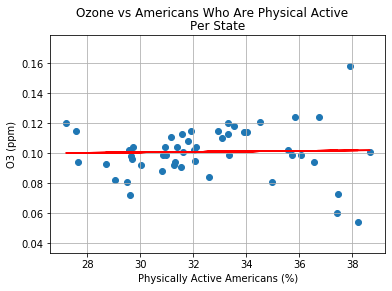

This data shows that states reporting higher max o3 levels have no correlation on percentage of physically active Americans


In [55]:
# No2 levels compared to physical activity
scatter_plot(merged_active["Data_Value"], merged_active["max o3"], True,  "Ozone vs Americans Who Are Physical Active", "Per State", "Physically Active Americans (%)", "O3 (ppm)")
# plt.xlabel("No2")
# plt.ylabel("Active")
plt.show()
print(f"This data shows that states reporting higher max o3 levels have no correlation on percentage of physically active Americans")

The r-squared is: -0.15360405008314845


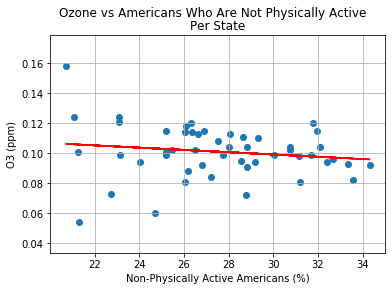

This data shows that states reporting lower max o3 levels report higher percentage of non-physically active people


In [58]:
# No2 levels compared to no physical activity
scatter_plot(merged_no_active["Data_Value"], merged_no_active["max o3"], True,  "Ozone vs Americans Who Are Not Physically Active", "Per State", "Non-Physically Active Americans (%)", "O3 (ppm)")
# plt.xlabel("No2")
# plt.ylabel("Active")
plt.show()
print(f"This data shows that states reporting lower max o3 levels report higher percentage of non-physically active people")

Obviously our data owned us and we got the exact opposite results that we were hypothesizing. Why?
-	Pollution is going to be higher near more densely populated cities, and people seem to be more physically active near urban centers. 
-	If we take the pollution data and run it per capita, would we find different results?

In [49]:
# Read in census 2017 population data

census2017 = pd.read_csv("census2017.csv")
census2017 = census2017.rename(columns= {"NAME": "state"})

In [50]:
census_air_df = pd.merge(census2017, clean_air_df, on="state")
census_air_df.head()

,state,POPESTIMATE2017,avg o3,max o3
0,Alabama,4874486,0.040627,0.094
1,Alaska,739700,0.028044,0.054
2,Arizona,7044008,0.049570,0.114
3,Arkansas,3001345,0.041574,0.093
4,California,39358497,0.046155,0.158


The r-squared is: 0.19398971367414947


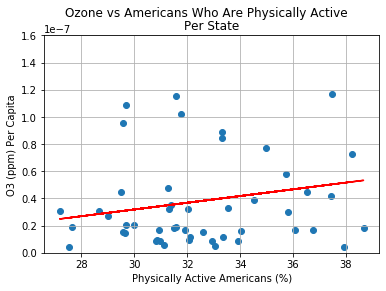

This shows that 


In [63]:
# create a column for o3 levels per capita and add it to the dataframe. Merge it to the active dataframe
o3_per_capita = census_air_df["max o3"] / census_air_df["POPESTIMATE2017"]

census_air_df["o3 per capita"] = o3_per_capita

merged_census_active = pd.merge(active_df, census_air_df, on="state")
merged_census_active.describe()

scatter_plot(merged_census_active["Data_Value"], merged_census_active["o3 per capita"], True, "Ozone vs Americans Who Are Physically Active", "Per State", "Physically Active Americans (%)", "O3 (ppm) Per Capita")
plt.ylim(0, 1.6e-07)
plt.show()
print(f"This data shows that states reporting higher max o3 levels per capita also report higher percentage of physically active people")

The r-squared is: -0.17598397472484362


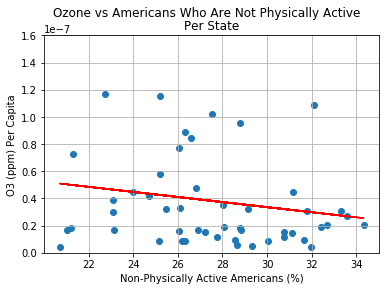

This data shows that states reporting lower max o3 levels per capita report higher percentage of non-physically active people


In [65]:
merged_census_no_active = pd.merge(no_active_df, census_air_df, on="state")
scatter_plot(merged_census_no_active["Data_Value"], merged_census_no_active["o3 per capita"], True, "Ozone vs Americans Who Are Not Physically Active", "Per State", "Non-Physically Active Americans (%)", "O3 (ppm) Per Capita")
plt.ylim(0, 1.6e-07)
plt.show()
print(f"This data shows that states reporting lower max o3 levels per capita report higher percentage of non-physically active people")